# Parkinsons Disease
The objective is to find a model which will be able to predict whether a person is likely to have parkinsons disease or not given their medical records.


In [50]:
!pip install scikit-learn-intelex

Defaulting to user installation because normal site-packages is not writeable


In [51]:
from sklearnex import patch_sklearn
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


<b>With Intel® Extension for Scikit-learn*, you can accelerate up to 10- 100x, 3 while conforming to scikit-learn APIs. <br>Ref: https://intel.github.io/scikit-learn-intelex/index.html

# Import Libraries 

In [118]:
import os
import cv2
import time
import numpy as np
from skimage import feature
from sklearn.preprocessing import LabelEncoder
from glob import glob

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from xgboost import XGBClassifier

from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

# Import Dataset

In [119]:
def get_image_names_in_folder(folder_path):
    image_names = []
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            if file.endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp')):
                image_names.append(os.path.join(root, file))
    return image_names

In [120]:
def preprocess_image(image_path, orientations, pixels_per_cell, cells_per_block, transform_sqrt, block_norm):
    label = image_path.split(os.path.sep)[-2]
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = cv2.resize(image, (200, 200))
    image = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
    features = feature.hog(image,
                           orientations=orientations,
                           pixels_per_cell=pixels_per_cell,
                           cells_per_block=cells_per_block,
                           transform_sqrt=transform_sqrt,
                           block_norm=block_norm)
    return features, label

In [121]:
PATH = "./dataset/spiral" 

X_PATH = os.path.sep.join([PATH, "training"])
y_PATH = os.path.sep.join([PATH, "testing"])


X_list = get_image_names_in_folder(X_PATH)
y_list = get_image_names_in_folder(y_PATH)

data = []
labels = []

# HOG feature extraction parameters
orientations = 9
pixels_per_cell = (10, 10)
cells_per_block = (2, 2)
transform_sqrt = True
block_norm = "L2"



data = []
labels = []

# Combine the lists of image paths
all_image_paths = X_list + y_list

# Process the images and extract features
for imagePath in all_image_paths:
    features, label = preprocess_image(imagePath, 
                                       orientations,
                                       pixels_per_cell, 
                                       cells_per_block, 
                                       transform_sqrt, 
                                       block_norm)
    data.append(features)
    labels.append(label)

# Convert data and labels lists to NumPy arrays
data = np.array(data)
labels = np.array(labels)

In [122]:
# Separate training and testing data
X_train, X_test, y_train ,y_test= data[:len(X_list)], data[len(y_list):], labels[:len(X_list)], labels[len(y_list):]

In [123]:
y_test

array(['parkinson', 'parkinson', 'parkinson', 'parkinson', 'parkinson',
       'parkinson', 'healthy', 'healthy', 'healthy', 'healthy', 'healthy',
       'healthy', 'healthy', 'healthy', 'healthy', 'healthy', 'healthy',
       'healthy', 'healthy', 'healthy', 'healthy', 'healthy', 'healthy',
       'healthy', 'healthy', 'healthy', 'healthy', 'healthy', 'healthy',
       'healthy', 'healthy', 'healthy', 'healthy', 'healthy', 'healthy',
       'healthy', 'healthy', 'healthy', 'healthy', 'healthy', 'healthy',
       'healthy', 'parkinson', 'parkinson', 'parkinson', 'parkinson',
       'parkinson', 'parkinson', 'parkinson', 'parkinson', 'parkinson',
       'parkinson', 'parkinson', 'parkinson', 'parkinson', 'parkinson',
       'parkinson', 'healthy', 'healthy', 'healthy', 'healthy', 'healthy',
       'healthy', 'healthy', 'healthy', 'healthy', 'healthy', 'healthy',
       'healthy', 'healthy', 'healthy', 'healthy'], dtype='<U9')

In [124]:
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

In [125]:
class BaseModel:
    def __init__(self, classifier):
        self.classifier = classifier
        self.accuracy = 0
        self.sensitivity = 0
        self.specificity = 0
        self.auc_score = 0
        self.fpr = 0
        self.tpr = 0
        self.thresh = 0

class RandomForestModel(BaseModel):
    def __init__(self):
        super().__init__(RandomForestClassifier(n_estimators=100, random_state=42))

class XGBModel(BaseModel):
    def __init__(self):
        super().__init__(XGBClassifier())

# Create instances of the models
models = {
    "Rf": RandomForestModel(),
    "Xgb": XGBModel()
}


In [98]:
def train_and_evaluate_model(classifier, X_train, y_train, X_test, y_test):
    classifier.fit(X_train, y_train)
    predictions = classifier.predict(X_test)
    predictions_probs = classifier.predict_proba(X_test)
    fpr, tpr, thresh = roc_curve(y_test, predictions_probs[:, 1])
    cm = confusion_matrix(y_test, predictions).ravel()
    tn, fp, fn, tp = cm
    
    return {
        "classifier": classifier,
        "accuracy": (tp + tn) / float(cm.sum()),
        "sensitivity": tp / float(tp + fn),
        "specificity": tn / float(tn + fp),
        "auc_score": roc_auc_score(y_test, predictions_probs[:, 1]),
        "fpr": fpr,
        "tpr": tpr,
        "thresh": thresh
    }

models = {
    "Rf": RandomForestClassifier(n_estimators=100, random_state=42),
    "Xgb": XGBClassifier(),
    'SVM':SVC(kernel='linear', probability=True),
    'GNB':GaussianNB(),
    'KNN':KNeighborsClassifier(n_neighbors=5),
    'DT':DecisionTreeClassifier()
}

In [62]:
start_time = time.time()
spiral_model = {}

for model_name, classifier in models.items():
    result = train_and_evaluate_model(classifier,
                                      X_train,
                                      y_train,
                                      X_test, 
                                      y_test)
    spiral_model[model_name] = result
end_time = time.time()

In [63]:
execution_time = end_time - start_time
print(f"Execution time: {execution_time} seconds")

Execution time: 0.9459247589111328 seconds


<b> As you can see, with Intel Optimizations, the time taken for training such a large dataset took only 0.94 seconds.

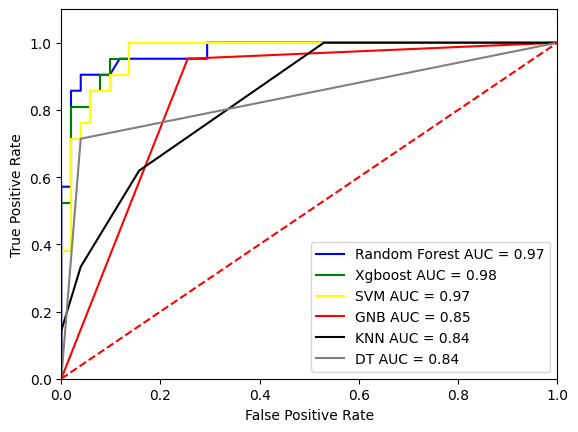

In [100]:
import matplotlib.pyplot as plt

# Create a list of model names and their corresponding colors for the plot
models_info = [
    ("Rf", "blue", "Random Forest"),
    ("Xgb", "green", "Xgboost"),
    ( "SVM", "yellow", "SVM"),
    ('GNB','red','GNB'),
    ('KNN','black','KNN'),
    ('DT','gray','DT')
]

for model_name, color, label_text in models_info:
    fpr = spiral_model[model_name]["fpr"]
    tpr = spiral_model[model_name]["tpr"]
    auc_score = spiral_model[model_name]["auc_score"]
    plt.plot(fpr, tpr, color=color, label=f'{label_text} AUC = {auc_score:.2f}')

plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0, 1])
plt.ylim([0, 1.1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


In [101]:
for metric in ("accuracy", "sensitivity", "specificity", "auc_score"):
    print(f"{metric.capitalize()}: ")
    print("Random Forrest={:.2f}%, XGBoost={:.2f}% ,SVM={:.2f}%\n".format(
        spiral_model['Rf'][metric]*100, spiral_model['Xgb'][metric]*100,spiral_model['SVM'][metric]*100))

Accuracy: 
Random Forrest=94.44%, XGBoost=91.67% ,SVM=91.67%

Sensitivity: 
Random Forrest=85.71%, XGBoost=80.95% ,SVM=85.71%

Specificity: 
Random Forrest=98.04%, XGBoost=96.08% ,SVM=94.12%

Auc_score: 
Random Forrest=97.34%, XGBoost=97.67% ,SVM=96.83%



<b>The accuracy is the same.

In [66]:
import random

output_images = []
# pick 15 images at random
for _ in range(9):
    image_path = random.choice(y_list)
    image = cv2.imread(image_path)
    output = image.copy()
    output = cv2.resize(output, (128, 128))
    # pre-process the image
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = cv2.resize(image, (200, 200))
    image = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
    # quantify the image and make predictions based on the extracted features
    features = feature.hog(image,
                           orientations=orientations,
                           pixels_per_cell=pixels_per_cell,
                           cells_per_block=cells_per_block,
                           transform_sqrt=transform_sqrt,
                           block_norm=block_norm)
    preds = spiral_model['Rf']['classifier'].predict([features])
    label = "Parkinsons" if preds[0] else "Healthy"

    # draw the colored class label on the output image and add it to
    # the set of output images
    color_dict = {"Healthy": (0, 255, 0), "Parkinsons": (255, 0, 255)}
    color = color_dict.get(label, (0, 0, 0))  # Set a default color (black) if label is not found in the dictionary

    cv2.putText(output, label, (3, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
    output_images.append(output)

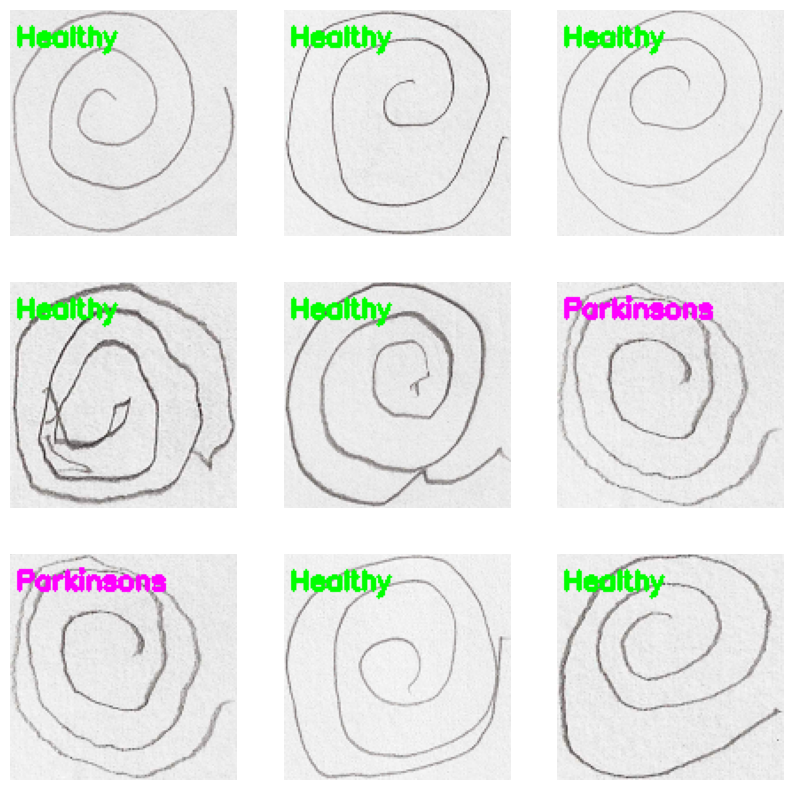

In [67]:
# Create a 3x3 grid of subplots
fig, axes = plt.subplots(3, 3, figsize=(10, 10))

# Flatten the axes array to iterate through the subplots easily
axes = axes.flatten()

for i, output_image in enumerate(output_images):
    axes[i].imshow(output_image)
    axes[i].axis("off")

# Remove any unused subplots
for j in range(i+1, len(axes)):
    axes[j].axis("off")

plt.show()


In [68]:
import joblib

filename = os.path.join("./", "random_forest_spiral_model.pkl")
joblib.dump(spiral_model['Rf']['classifier'], filename)

['./random_forest_spiral_model.pkl']

In [69]:
filename = os.path.join("./", "XGBOOST_spiral_model.pkl")
joblib.dump(spiral_model['Xgb']['classifier'], filename)

['./XGBOOST_spiral_model.pkl']

In [126]:
PATH = "./dataset/wave" 

X_PATH = os.path.sep.join([PATH, "training"])
y_PATH = os.path.sep.join([PATH, "testing"])


X_list = get_image_names_in_folder(X_PATH)
y_list = get_image_names_in_folder(y_PATH)

data = []
labels = []

# HOG feature extraction parameters
orientations = 9
pixels_per_cell = (10, 10)
cells_per_block = (2, 2)
transform_sqrt = True
block_norm = "L2"



data = []
labels = []

# Combine the lists of image paths
all_image_paths = X_list + y_list

# Process the images and extract features
for imagePath in all_image_paths:
    features, label = preprocess_image(imagePath, 
                                       orientations,
                                       pixels_per_cell, 
                                       cells_per_block, 
                                       transform_sqrt, 
                                       block_norm)
    data.append(features)
    labels.append(label)

# Convert data and labels lists to NumPy arrays
data = np.array(data)
labels = np.array(labels)

# Separate training and testing data
X_train, X_test, y_train ,y_test= data[:len(X_list)], data[len(y_list):], labels[:len(X_list)], labels[len(y_list):]


In [127]:
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

In [128]:
class BaseModel:
    def __init__(self, classifier):
        self.classifier = classifier
        self.accuracy = 0
        self.sensitivity = 0
        self.specificity = 0
        self.auc_score = 0
        self.fpr = 0
        self.tpr = 0
        self.thresh = 0

class RandomForestModel(BaseModel):
    def __init__(self):
        super().__init__(RandomForestClassifier(n_estimators=100, random_state=42))

class XGBModel(BaseModel):
    def __init__(self):
        super().__init__(XGBClassifier())

# Create instances of the models
models = {
    "Rf": RandomForestModel(),
    "Xgb": XGBModel()
}

In [129]:
def train_and_evaluate_model(classifier, X_train, y_train, X_test, y_test):
    classifier.fit(X_train, y_train)
    predictions = classifier.predict(X_test)
    predictions_probs = classifier.predict_proba(X_test)
    fpr, tpr, thresh = roc_curve(y_test, predictions_probs[:, 1])
    cm = confusion_matrix(y_test, predictions).ravel()
    tn, fp, fn, tp = cm
    
    return {
        "classifier": classifier,
        "accuracy": (tp + tn) / float(cm.sum()),
        "sensitivity": tp / float(tp + fn),
        "specificity": tn / float(tn + fp),
        "auc_score": roc_auc_score(y_test, predictions_probs[:, 1]),
        "fpr": fpr,
        "tpr": tpr,
        "thresh": thresh
    }

models = {
    "Rf": RandomForestClassifier(n_estimators=100, random_state=42),
    "Xgb": XGBClassifier(),
    'SVM':SVC(kernel='linear', probability=True),
    'GNB':GaussianNB(),
    'KNN':KNeighborsClassifier(n_neighbors=5),
    'DT':DecisionTreeClassifier()
}

In [74]:
start_time = time.time()
wave_model = {}

for model_name, classifier in models.items():
    result = train_and_evaluate_model(classifier,
                                      X_train,
                                      y_train,
                                      X_test, 
                                      y_test)
    wave_model[model_name] = result
end_time = time.time()

In [75]:
execution_time = end_time - start_time
print(f"Execution time: {execution_time} seconds")

Execution time: 1.0033106803894043 seconds


<b> As you can see, with Intel Optimizations, the time taken for training such a large dataset took only 1.00 seconds.

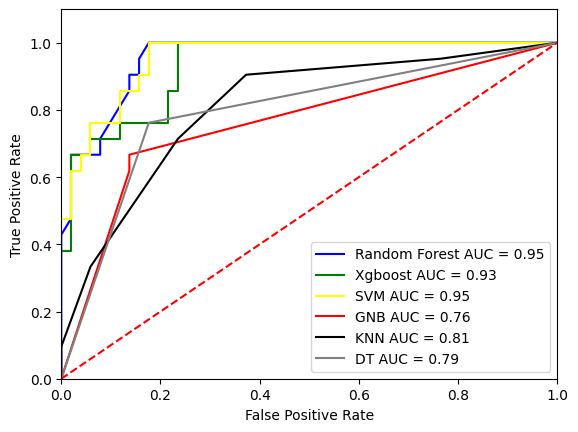

In [131]:
import matplotlib.pyplot as plt

# Create a list of model names and their corresponding colors for the plot
models_info = [
    ("Rf", "blue", "Random Forest"),
    ("Xgb", "green", "Xgboost"),
    ( "SVM", "yellow", "SVM"),
    ('GNB','red','GNB'),
    ('KNN','black','KNN'),
    ('DT','gray','DT')
]

for model_name, color, label_text in models_info:
    fpr = wave_model[model_name]["fpr"]
    tpr = wave_model[model_name]["tpr"]
    auc_score = wave_model[model_name]["auc_score"]
    plt.plot(fpr, tpr, color=color, label=f'{label_text} AUC = {auc_score:.2f}')

plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0, 1])
plt.ylim([0, 1.1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


In [132]:
for metric in ("accuracy", "sensitivity", "specificity", "auc_score"):
    print(f"{metric.capitalize()}: ")
    print("Random Forrest={:.2f}%, XGBoost={:.2f}% ,SVM={:.2f}%\n".format(
        wave_model['Rf'][metric]*100, wave_model['Xgb'][metric]*100,wave_model['SVM'][metric]*100))

Accuracy: 
Random Forrest=86.11%, XGBoost=83.33% ,SVM=88.89%

Sensitivity: 
Random Forrest=71.43%, XGBoost=71.43% ,SVM=76.19%

Specificity: 
Random Forrest=92.16%, XGBoost=88.24% ,SVM=94.12%

Auc_score: 
Random Forrest=95.47%, XGBoost=93.18% ,SVM=95.42%



In [78]:
import random

output_images = []
# pick 15 images at random
for _ in range(9):
    image_path = random.choice(y_list)
    image = cv2.imread(image_path)
    output = image.copy()
    output = cv2.resize(output, (128, 128))
    # pre-process the image
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = cv2.resize(image, (200, 200))
    image = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
    # quantify the image and make predictions based on the extracted features
    features = feature.hog(image,
                           orientations=orientations,
                           pixels_per_cell=pixels_per_cell,
                           cells_per_block=cells_per_block,
                           transform_sqrt=transform_sqrt,
                           block_norm=block_norm)
    preds = spiral_model['Rf']['classifier'].predict([features])
    label = "Parkinsons" if preds[0] else "Healthy"

    # draw the colored class label on the output image and add it to
    # the set of output images
    color_dict = {"Healthy": (0, 255, 0), "Parkinsons": (255, 0, 255)}
    color = color_dict.get(label, (0, 0, 0))  # Set a default color (black) if label is not found in the dictionary

    cv2.putText(output, label, (3, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
    output_images.append(output)

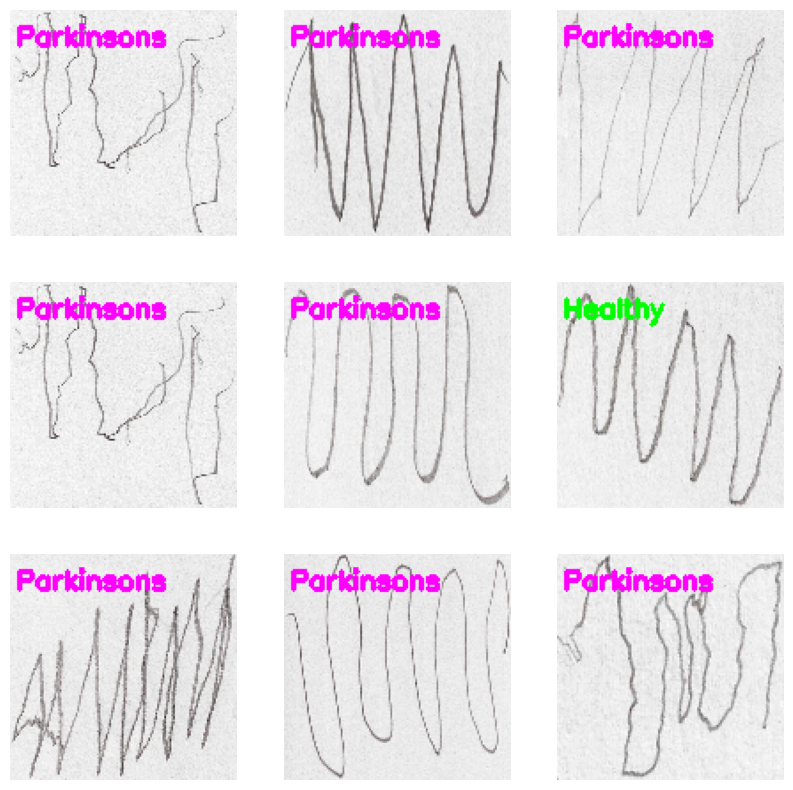

In [79]:
# Create a 3x3 grid of subplots
fig, axes = plt.subplots(3, 3, figsize=(10, 10))

# Flatten the axes array to iterate through the subplots easily
axes = axes.flatten()

for i, output_image in enumerate(output_images):
    axes[i].imshow(output_image)
    axes[i].axis("off")

# Remove any unused subplots
for j in range(i+1, len(axes)):
    axes[j].axis("off")

plt.show()


In [80]:
import joblib

filename = os.path.join("./", "random_forest_wave_model.pkl")
joblib.dump(wave_model['Rf']['classifier'], filename)

['./random_forest_wave_model.pkl']

In [81]:
filename = os.path.join("./", "XGBOOST_wave_model.pkl")
joblib.dump(wave_model['Xgb']['classifier'], filename)

['./XGBOOST_wave_model.pkl']